# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |


* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\teres\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\teres\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [2]:
##  python model....

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

py_model = Model('pypredprey', function=pred_prey)

py_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)]

# model.levers = [RealParameter('initial_prey', 25, 75),
# #                 RealParameter('initial_predators', 10,30)]

# py_model.constants = [Constant('final_time', 365),
#                     Constant('dt', 0.25)]

py_model.outcomes =  [TimeSeriesOutcome('predators'), TimeSeriesOutcome('prey')]

In [3]:
# run the experiments python
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator ,ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(py_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000)

# print(experiments)
# print(outcomes)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [4]:
experiments, outcomes = results
outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()} # Important for printing, delete redundant array

# For printing

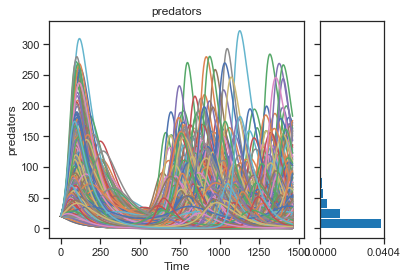

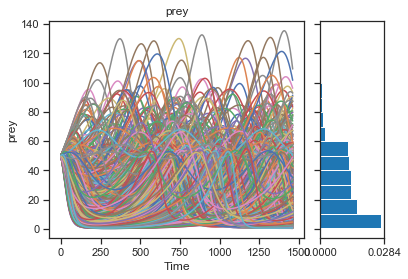

In [5]:
from ema_workbench.analysis import plotting, plotting_util
import matplotlib.pyplot as plt # TO DO; plot the scalers.
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# experiments, outcomes = results
# print(experiments.shape)
# print(list(outcomes.keys()))
# print(outcomes)
# outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()} # Important for printing, delete redundant array.
# print(outcomes)

for outcome in outcomes.keys():
    # print(outcome)
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting_util.Density.HIST)
plt.show()

# statsmodels regression (OLS)
* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment

### Predator_final

                            OLS Regression Results                            
Dep. Variable:        predators_final   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     65.13
Date:                Fri, 15 May 2020   Prob (F-statistic):           5.86e-49
Time:                        11:19:16   Log-Likelihood:                -4578.0
No. Observations:                1000   AIC:                             9166.
Df Residuals:                     995   BIC:                             9191.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.4542    

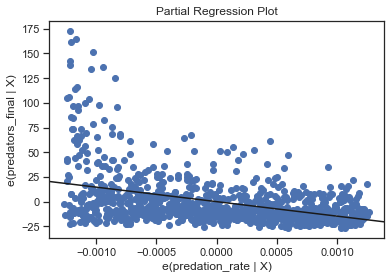

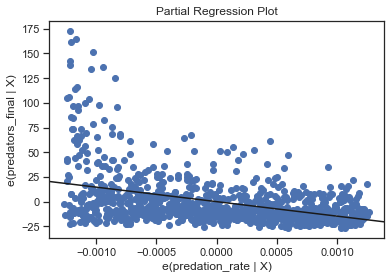

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices

ols_data =  experiments.drop(['scenario'], axis=1)
ols_data['predators_final'] = outcomes['predators'][:,-1] # The final values of the prey outcome
ols_data['predators_mean'] = np.mean(outcomes['predators'][:,:],axis=1) # The mean values of the prey outcome over time, within each experiment
ols_data['predators_std'] = np.std(outcomes['predators'][:,:],axis=1) # The standard deviations of the prey outcome over time, within each 

y, X= dmatrices('predators_final ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate', data = ols_data, return_type='dataframe')

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

print(sm.stats.linear_rainbow(res))
sm.graphics.plot_partregress('predators_final', 'predation_rate', ['predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'],
                             data = ols_data, 
                             obs_labels=False)

### Prey_mean

                            OLS Regression Results                            
Dep. Variable:              prey_mean   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1572.
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        11:19:51   Log-Likelihood:                -2984.6
No. Observations:                1000   AIC:                             5979.
Df Residuals:                     995   BIC:                             6004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.2141    

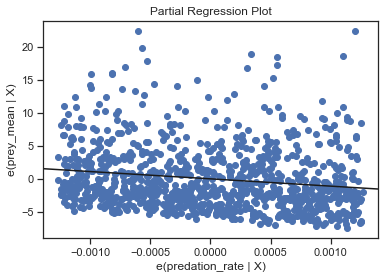

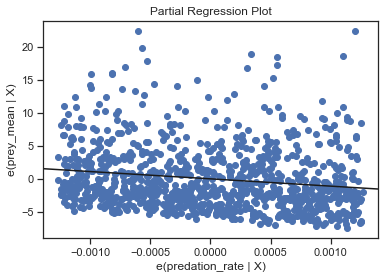

In [7]:
data_for_fit =  experiments.drop(['scenario'], axis=1)
data_for_fit['prey_final'] = outcomes['prey'][:,-1] # The final values of the prey outcome
data_for_fit['prey_mean'] = np.mean(outcomes['prey'][:,:],axis=1) # The mean values of the prey outcome over time, within each experiment
data_for_fit['prey_std'] = np.std(outcomes['prey'][:,:],axis=1) # The standard deviations of the prey outcome over time, within each experiment

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices

y1, X1= dmatrices('prey_mean ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate', data = data_for_fit, return_type='dataframe')
# prey_mean can be changed into prey_final and prey_std

mod1 = sm.OLS(y1,X1) 
res1 = mod1.fit()
print(res1.summary())

print(sm.stats.linear_rainbow(res1))
sm.graphics.plot_partregress('prey_mean', 'predation_rate', ['predator_efficiency', 'predator_loss_rate','prey_birth_rate'],
                             data = data_for_fit, 
                             obs_labels=False)

### Prey_std

                            OLS Regression Results                            
Dep. Variable:               prey_std   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     24.34
Date:                Fri, 15 May 2020   Prob (F-statistic):           3.05e-19
Time:                        11:20:40   Log-Likelihood:                -2600.7
No. Observations:                1000   AIC:                             5211.
Df Residuals:                     995   BIC:                             5236.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.9383    

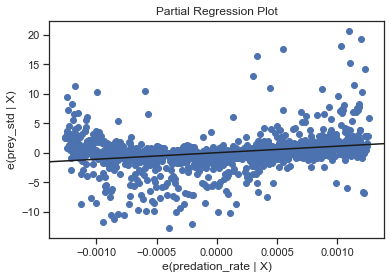

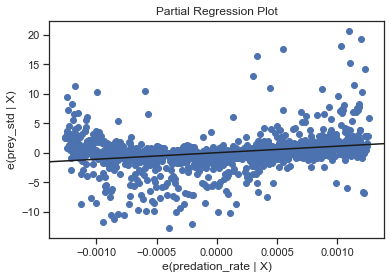

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices

y2, X2= dmatrices('prey_std ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate', data = data_for_fit, return_type='dataframe')
# prey_final can be changed into prey_mean and prey_std

mod2 = sm.OLS(y2,X2) 
res2 = mod2.fit()
print(res2.summary())
print(sm.stats.linear_rainbow(res2))
sm.graphics.plot_partregress('prey_std', 'predation_rate', ['predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'],
                             data = data_for_fit, 
                             obs_labels=False)

# sobol analysis
* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

### N = 50

In [9]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(py_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios = 50 ,
                                               uncertainty_sampling='sobol')

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


In [10]:
experiments, outcomes = sa_results
outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()}

In [11]:
problem = get_SALib_problem(py_model.uncertainties)

In [12]:
Si = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)

In [13]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index = problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
predation_rate,0.127158,0.104681,0.093433,0.142257
predator_efficiency,0.861776,0.414012,0.467832,0.334404
predator_loss_rate,0.586328,0.293794,0.106056,0.249154
prey_birth_rate,0.509988,0.251470,0.067219,0.343613


### N = 250

In [44]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(py_model) as evaluator:
    sa_results_1 = evaluator.perform_experiments(scenarios = 250 ,
                                               uncertainty_sampling='sobol')

[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


In [45]:
experiments_1, outcomes_1 = sa_results_1
outcomes_1 = {key:outcomes_1[key][:,0,:] for key in outcomes_1.keys()}

In [46]:
problem_1 = get_SALib_problem(py_model.uncertainties)
Si_1 = sobol.analyze(problem_1, outcomes_1['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)

In [47]:
Si_filter_1 = {k:Si_1[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_1 = pd.DataFrame(Si_filter_1, index = problem['names'])
Si_df_1

,ST,ST_conf,S1,S1_conf
predation_rate,0.123294,0.035467,0.054258,0.050061
predator_efficiency,0.852120,0.164233,0.279763,0.130453
predator_loss_rate,0.606673,0.128645,0.017445,0.110537
prey_birth_rate,0.565059,0.112587,-0.044853,0.095114


### N = 1000

In [35]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(py_model) as evaluator:
    sa_results_2 = evaluator.perform_experiments(scenarios = 1000 ,
                                               uncertainty_sampling='sobol')
    

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [36]:
experiments_2, outcomes_2 = sa_results_2
outcomes_2 = {key:outcomes_2[key][:,0,:] for key in outcomes_2.keys()}

In [37]:
problem_2 = get_SALib_problem(py_model.uncertainties)
Si_2 = sobol.analyze(problem_2, outcomes_2['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)

In [38]:
Si_filter_2 = {k:Si_2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_2 = pd.DataFrame(Si_filter_2, index = problem['names'])
Si_df_2

,ST,ST_conf,S1,S1_conf
predation_rate,0.132785,0.031878,-0.002546,0.030197
predator_efficiency,0.809377,0.077250,0.407665,0.067846
predator_loss_rate,0.585974,0.066257,0.079809,0.061775
prey_birth_rate,0.511565,0.055219,0.030426,0.062668


# Extra trees

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

Run code above, with n=1000 for sobol.

In [48]:
extra_trees_results = sa_results_1

In [53]:
tree_experiments, tree_outcomes = extra_trees_results
tree_outcomes = {key:tree_outcomes[key][:,0, -1] for key in tree_outcomes.keys()} # Important for printing, delete redundant array
tree_experiments = tree_experiments.drop(columns=['scenario', 'policy', 'model'], inplace=False)
print(tree_experiments.head(5))

   predation_rate  predator_efficiency  predator_loss_rate  prey_birth_rate
0        0.001049             0.001290            0.060742         0.028535
1        0.001201             0.001290            0.060742         0.028535
2        0.001049             0.003722            0.060742         0.028535
3        0.001049             0.001290            0.041836         0.028535
4        0.001049             0.001290            0.060742         0.032988


In [54]:
from ema_workbench.analysis import feature_scoring
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

score = feature_scoring.get_feature_scores_all(tree_experiments, tree_outcomes)

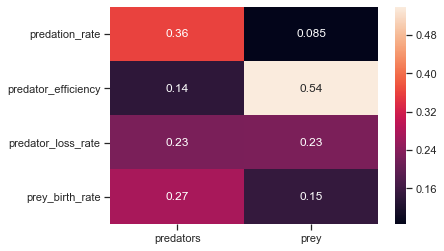

In [55]:
sns.heatmap(score, annot=True)
plt.show()

### Sobal slices vs Extra-trees
We also use the prey_final value in extra-trees here, and compare the results with the ones in sobol slices

In [59]:
scores, p_values = feature_scoring.get_rf_feature_scores(tree_experiments,tree_outcomes['prey'],  mode=RuleInductionType.REGRESSION, 
                                                         nr_trees=100, max_features=0.6)

In [60]:
scores

,1
0,
predator_efficiency,0.465286
predator_loss_rate,0.230191
prey_birth_rate,0.208645
predation_rate,0.095878


In [63]:
Si_df_1['ST']

predation_rate         0.123294
predator_efficiency    0.852120
predator_loss_rate     0.606673
prey_birth_rate        0.565059
Name: ST, dtype: float64